### load the data

In [1]:
from data_processing import process_table, load_ranges_file, process_cleaned_data
import argparse
import numpy as np
import pandas as pd
from pymol import cmd


parser = argparse.ArgumentParser(description='Statistical analysis of HDX/MS data for curated RbsR peptides in one or more functional states.')
parser.add_argument('--pm', dest='pm', help="path to pymol structure", required=True)
parser.add_argument('--t', '--table', dest='table', help="path to uptake table", nargs='+', required=True)
parser.add_argument('--r', '--ranges', dest='ranges', help='path to ranges list csv')
parser.add_argument('--e', '--exclude', dest='exclude', action='store_true', help='exclude rather than include rangeslist')
parser.add_argument('--s1', dest='s1', help='first state to compare')
parser.add_argument('--s2', dest='s2', help='second state to compare')
parser.add_argument('--compare', dest='compare', help='dna, ligand, both', nargs=3)
parser.add_argument('--cbarmax', dest='cbarmax', type=float, help='max value for colorbar axis for dDbar')
parser.add_argument('--ldmin', dest='ldmin', type=float, help='in dDbar, minimum difference threshold between ligand/dna states')



args = parser.parse_args(args=['--t', './EcPFK_20230707_BioRep1/peptide_pool_20230724.csv','./EcPFK_20230424/peptide_pool_20230502.csv'
                               '--r', './EcPFK_20230707_BioRep1/ranges_list_e.csv', 
                               '--pm', './EcPFK_20230424/1pfk_Xray.pdb',
                               '--e'])

args.table = ['./EcPFK_20230707_BioRep1/peptide_pool_20230724.csv',
              './EcPFK_20230424/peptide_pool_20230502.csv',
              './EcPFK_20230707_BioRep2/ecpfk_biorep2_fum_only_plus_biorep1_pooled_peptide_pool_result_apo-adp-pep.csv']
args.ranges = ['./EcPFK_20230707_BioRep1/ranges_list_e.csv', 
               './EcPFK_20230424/rangeslist_e.csv',
               './EcPFK_20230707_BioRep2/rangelist_e.csv']



In [2]:
print(args)
cmd.load(args.pm)
global colorbar_max, delta_LD_threshold
colorbar_max = 0.05 if args.cbarmax is None else args.cbarmax
delta_LD_threshold = 0.075 if args.ldmin is None else args.ldmin



from data_processing import get_unique_sorted, create_sequence_dict

newbigdf = pd.DataFrame()

cleaned_list = []
# Process all tables
for table, range_file in zip(args.table[:2], args.ranges[:2]):
    newbigdf = process_table(table)

    # Convert columns to the appropriate data types
    newbigdf['Start'] = newbigdf['Start'].apply(np.int64)
    newbigdf['End'] = newbigdf['End'].apply(np.int64)
    newbigdf['#D'] = newbigdf['#D'].apply(float)



    cleaned  = load_ranges_file(range_file, newbigdf, args.exclude)
    cleaned_list.append(cleaned)

cleaned = pd.concat(cleaned_list, ignore_index=True)
cleaned = process_cleaned_data(cleaned)



Namespace(cbarmax=None, compare=None, exclude=True, ldmin=None, pm='./EcPFK_20230424/1pfk_Xray.pdb', ranges=['./EcPFK_20230707_BioRep1/ranges_list_e.csv', './EcPFK_20230424/rangeslist_e.csv', './EcPFK_20230707_BioRep2/rangelist_e.csv'], s1=None, s2=None, table=['./EcPFK_20230707_BioRep1/peptide_pool_20230724.csv', './EcPFK_20230424/peptide_pool_20230502.csv', './EcPFK_20230707_BioRep2/ecpfk_biorep2_fum_only_plus_biorep1_pooled_peptide_pool_result_apo-adp-pep.csv'])
rangeslist excluded !
rangeslist excluded !


In [3]:
state_mask = cleaned['Protein State'].isin(['APO', 'ADP', 'PEP'])
cleaned = cleaned[state_mask]

In [4]:
cleaned

,Sequence,Deut Time (sec),Protein State,Start,End,#D,Stddev,#Rep
868,MHHHHHHENL,0.0,ADP,1,10,0.000000,0.000000,1
869,MHHHHHHENL,0.0,APO,1,10,0.000000,0.000000,1
871,MHHHHHHENL,0.0,PEP,1,10,0.000000,0.000000,1
4004,MHHHHHHENL,30.0,ADP,1,10,0.214667,0.064655,3
4005,MHHHHHHENL,30.0,APO,1,10,0.095667,0.019425,3
...,...,...,...,...,...,...,...,...
1258,EKM,1920.0,APO,330,332,0.046000,NaN,1
1261,EKM,1920.0,PEP,330,332,0.061000,NaN,1
1262,EKM,7680.0,ADP,330,332,0.113000,NaN,1
1263,EKM,7680.0,APO,330,332,0.044000,NaN,1


### clean the data

In [5]:

states = list(dict.fromkeys(cleaned['Protein State']))
#states.sort()
peptides = list(dict.fromkeys(cleaned['Sequence']))
#peptides.sort()
timepoints = list(dict.fromkeys(cleaned['Deut Time (sec)']))
timepoints.sort()


states_dict, first_res, peptides_2 = create_sequence_dict(cleaned, states)

In [6]:
timepoints

[0.0, 30.0, 120.0, 480.0, 1920.0, 7680.0]

### non linear fitting of the data

In [7]:
from utils import compile_exchange_info, fit_functions


# Compile the exchange information
peptide_exchange_dict, stdev_dict_dict = compile_exchange_info(cleaned, states, states_dict)

# Fit the exchange functions
trialT, peptide_fit_dict, peptide_params_dict, peptide_err_dict = fit_functions(peptides, peptide_exchange_dict, timepoints)


/Users/chenlin/opt/anaconda3/envs/openmm/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


### plot the uptake plots

In [ ]:
import matplotlib.pyplot as plt
from plot_functions import assign_colors, create_plot, handle_element, handle_list_item, adjust_plot, save_plot

#color_dict = assign_colors(states)
color_dict = {'APO':'#4A7DC7', 'ADP':'#D43B45', 'PEP':'#D69442'}
ax1 = create_plot()

for peptide in peptide_exchange_dict:
    element = peptide_exchange_dict.get(peptide)
    if element is not None:
        #print(f"Plotting {peptide}")
        handle_element(peptide, element, timepoints, stdev_dict_dict, color_dict, peptide_fit_dict, ax1, trialT)
        for list_item in peptides_2:
            plot_title, y_lim = handle_list_item(list_item, peptide, ax1, peptides_2)
            if plot_title and y_lim is not None:
                adjust_plot(ax1, plot_title, y_lim)
                save_plot(plot_title)
        ax1.clear()

plt.close('all')

### plot pymol session

In [9]:
def generate_pairs(states, args):
    pairs = []
    if len(states) > 1:
        for state1 in states:
            for state2 in states:
                if state1 != state2 and (state2, state1) not in pairs:
                    # Prioritize "APO" or "apo" to be the first element
                    if state1.lower() == 'apo':
                        pairs.append((state1, state2))
                    elif state2.lower() == 'apo':
                        pairs.append((state2, state1))
                    else:
                        pairs.append((state1, state2))
                    
        if (args.s1 is not None) and (args.s2 is not None):
            # Prioritize "APO" or "apo" to be the first element
            if args.s1.lower() == 'apo':
                pairs.append((args.s1, args.s2))
            elif args.s2.lower() == 'apo':
                pairs.append((args.s2, args.s1))
            else:
                pairs.append((args.s1, args.s2))
                
    return pairs




# Create a function to calculate differential expressions
def calculate_differential(pairs, peptide_exchange_dict, peptides_2, timepoints):
    dDt_tps_dict_dict = {}
    dDS_dict_dict = {}
    dDbar_dict_dict = {}

    for pair in pairs:
        dDt_tps_dict, dDS_dict, dDbar_dict = {}, {}, {}

        for peptide in peptide_exchange_dict:
            # dDt_tps = [np.array(peptide_exchange_dict.get(peptide).get(key)) for key in peptide_exchange_dict.get(peptide) if key in pair]
            dDt_tps = [np.array(peptide_exchange_dict.get(peptide).get(key)) for key in pair] 

            if dDt_tps[0].size == dDt_tps[1].size:
                dDS = (dDt_tps[0] - dDt_tps[1])/(len(peptide) - 2 - peptide[2:].count('P'))
                n_T = len(dDS)
                dDS_dict[peptide] = [np.nansum(dDS)]
                dDbar_dict[peptide] = [np.nansum(dDS)/n_T]
                dDt_tps = (dDt_tps[0] - dDt_tps[1])/(len(peptide) - 2 - peptide[2:].count('P'))
                dDt_tps_dict[peptide] = dDt_tps

        # save dict for each pair
        dDt_tps_dict_dict[pair] = dDt_tps_dict
        dDS_dict_dict[pair] = dDS_dict
        dDbar_dict_dict[pair] = dDbar_dict

        # Generating lists for heatmap
        heatmap_timepoints, heatmap_peptides, heatmap_values = generate_heatmap_lists(peptides_2, timepoints, dDt_tps_dict)


        # Create a heatmap
        #heatmap_df = create_heatmap_tp(heatmap_timepoints, heatmap_peptides, heatmap_values, pair)



        # TODO: Continue splitting into functions
        ...

    return  dDt_tps_dict_dict, dDS_dict_dict, dDbar_dict_dict

# Create a function to generate heatmap lists
def generate_heatmap_lists(peptides_2, timepoints, dDt_tps_dict):
    heatmap_timepoints = timepoints * len(peptides_2)
    heatmap_peptides = []
    heatmap_values = []

    for peptide in peptides_2:
        temp_peptides = [peptide]*len(timepoints)
        heatmap_peptides.append(temp_peptides)
        if peptide.split()[1] in dDt_tps_dict.keys():
            heatmap_values = heatmap_values + (list(dDt_tps_dict[peptide.split()[1]][:,0]))

    flat_list = [item for sublist in heatmap_peptides for item in sublist]

    return heatmap_timepoints, flat_list, heatmap_values

import seaborn as sns

# Create a function to create a heatmap
def create_heatmap_tp(heatmap_timepoints, flat_list, heatmap_values, pair):
    #print(heatmap_timepoints, flat_list, heatmap_values)
    heatmap_df = pd.DataFrame({'Timepoints (seconds)': heatmap_timepoints, 'Peptides': flat_list, 'Sensitivity': heatmap_values })

    # Plot it
    font = {'family' : 'Arial',
            'weight' : 'normal',
            'size'   : 14
        }
    axes = {'titlesize' : 18,
            'titleweight' : 'bold',
            'labelsize' : 16
        }

    plt.rc('font', **font)
    plt.rc('axes', **axes)

    plt.rcParams['figure.figsize'] = (4, 25)
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.family'] = 'Arial'

    df_wide=heatmap_df.pivot_table( index='Peptides', columns='Timepoints (seconds)', values='Sensitivity' )
    df_wide.index = pd.CategoricalIndex(df_wide.index, categories = peptides_2)
    df_wide.sort_index(level=0, inplace=True)

    cmap = sns.color_palette("vlag", as_cmap=True)
    fig = plt.figure()
    p2 = sns.heatmap( df_wide, cmap='RdBu', linewidths=.75, vmin=-colorbar_max, vmax=colorbar_max)
    p2.set_title("\u0394HX$_{t}$, " + pair[0] + ' - ' + pair[1])
    plt.savefig('plots/dHXt_' + pair[0] + '_' + pair[1] + '.png', bbox_inches="tight")


    return heatmap_df




In [10]:
pairs = generate_pairs(states, args)
dDt_tps_dict_dict, dDS_dict_dict, dDbar_dict_dict = calculate_differential(pairs, peptide_exchange_dict, peptides_2, timepoints)

In [11]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def reps_df_generation(reps_df, states):
    new_reps_df = pd.DataFrame()
    for sequence in set(reps_df['Sequence']):
        new_row = [sequence]
        for state in states:
            reps_sum = reps_df.loc[(reps_df['Sequence']==sequence) & (reps_df['Protein State']==state)]['#Rep'].sum()
            new_row.append(reps_sum)
        new_reps_df = pd.concat([new_reps_df, pd.DataFrame([new_row], columns=['Sequence']+states)])
    return new_reps_df.to_dict('records')

def get_dicts(pair, stdev_dict_dict):
    return {key: stdev_dict_dict[key] for key in stdev_dict_dict.keys() if key in pair}

def process_dicts(dict1, dict2, reps_dict_list, pair):
    u_dHXt = []
    for (k, v), (_, v2) in zip(dict1.items(), dict2.items()):
        squared_mA, squared_mB = [number ** 2 for number in v], [number ** 2 for number in v2]
        n_mA, n_mB = [el[p] for el in reps_dict_list if el["Sequence"] == k for p in pair]
        u_dDt = [math.sqrt( (a/n_mA) + (b/n_mB) ) for a, b in zip(squared_mA, squared_mB)]
        max_protons = len(k) - 2 - k[2:].count('P')
        u_dHXt.extend([ (el**2)/max_protons for el in u_dDt])
    return u_dHXt

def process_dDbar_df(pair, peptides_2, dDbar_dict_dict):
    dDbar_dict = dDbar_dict_dict.get(tuple(pair))
    #print(pair)
    return pd.DataFrame({
        'dDbar': 'dDbar', 'Sequence': peptides_2,
        'Sensitivity': [dDbar_dict[peptide.split()[1]][0] for peptide in peptides_2],
        'seq': [peptide.split(' ')[1] for peptide in peptides_2],
        'Start': [int(float(peptide.split('-')[0])) for peptide in peptides_2],
        'End': [int(float(peptide.split('-')[1])) for peptide in peptides_2]
    })

def create_heatmap(dDbar_heatmap_df, pair, colorbar_max):

    dDbar_df_wide = dDbar_heatmap_df.pivot_table(index='Sequence', columns='dDbar', values='Sensitivity')
    dDbar_df_wide.index = pd.CategoricalIndex(dDbar_df_wide.index, categories=peptides_2)
    dDbar_df_wide.sort_index(level=0, inplace=True)
    fig = plt.figure()
    p2 = sns.heatmap(dDbar_df_wide, cmap="RdBu", linewidths=1, vmin=-colorbar_max, vmax=colorbar_max)
    p2.set_title(pair[0] + '-\n' + pair[1])
    plt.close()

def save_df_plot(pair, df, colormap, colorbar_max, index_shift=0):

    # Plot it
    font = {'family' : 'Arial',
            'weight' : 'normal',
            'size'   : 14
        }
    axes = {'titlesize' : 18,
            'titleweight' : 'bold',
            'labelsize' : 16
        }

    plt.rc('font', **font)
    plt.rc('axes', **axes)

    plt.rcParams['figure.figsize'] = (4, 25)
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.family'] = 'Arial'


    df.sort_values(by=['Start','End'], inplace=True)
    df['Start'] = df['Start'] + index_shift
    df['End'] = df['End'] + index_shift

    fig, ax = plt.subplots(figsize=(20,10))
    leftbound = df['Start'][0]-10
    rightbound = max(df['End'])+10
    ax.set_xlim(leftbound,rightbound)
    ax.xaxis.set_ticks(np.arange(round(leftbound,-1), round(rightbound,-1), 10))
    ax.set_ylim(-5,110)
    ax.grid(axis='x')
    ax.yaxis.set_ticks([])
    norm = col.Normalize(vmin=-colorbar_max,vmax=colorbar_max)
    for i in range(len(df['Start'])):
        ax.add_patch(Rectangle((df['Start'][i], (i%20)*5 + ((i//20)%2)*2.5), df['End'][i]-df['Start'][i],4, fc=colormap(norm(df['Sensitivity'][i]))))
    fig.colorbar(cm.ScalarMappable(cmap=colormap, norm=norm))
    #plt.close()
    plt.title(pair[0] + ' - ' + pair[1])
    plt.savefig('plots/dHX_' + pair[0] + '_' + pair[1] + '.png', bbox_inches="tight")
    

def save_residue_array(dDbar_heatmap_df, pair):
    fullseq = cmd.get_fastastr('all').split('>')[1]
    fullseq = ''.join(fullseq.split('\n')[1:])
    residue_array = np.full(len(fullseq), np.nan)
    sorted_heatmap_df = dDbar_heatmap_df.sort_values(by='seq', key=lambda ser: [len(s) for s in ser], ascending=False)
    for i in range(len(sorted_heatmap_df['seq'])):
        residue_array[sorted_heatmap_df['Start'][i]:sorted_heatmap_df['End'][i]] = sorted_heatmap_df['Sensitivity'][i]
    np.savetxt(f'plots/dD_res_level_{pair[0]}_{pair[1]}.csv', residue_array, delimiter=',')

reps_df = cleaned[['#Rep', 'Sequence', 'Protein State']]
reps_dict_list = reps_df_generation(reps_df, states)

for pair in pairs:
    dicts = get_dicts(pair, stdev_dict_dict)
    process_dicts(*dicts.values(), reps_dict_list, pair)

    try:
        dDbar_heatmap_df = process_dDbar_df(pair, peptides_2, dDbar_dict_dict)
        dDbar_heatmap_df.to_csv(f'plots/peptide_df_{pair[0]}_{pair[1]}')
    except:
        pass # No peptides in common
    create_heatmap(dDbar_heatmap_df, pair, colorbar_max)
    save_residue_array(dDbar_heatmap_df, pair)


/var/folders/jj/7d28rm8x3_1frkhmtn_0_3yc0000gn/T/ipykernel_63248/1860922015.py:86: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cm.ScalarMappable(cmap=colormap, norm=norm))
/var/folders/jj/7d28rm8x3_1frkhmtn_0_3yc0000gn/T/ipykernel_63248/1860922015.py:86: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cm.ScalarMappable(cmap=colormap, norm=norm))
/var/folders/jj/7d28rm8x3_1frkhmtn_0_3yc0000gn/T/ipykernel_63248/1860922015.py:86: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for C

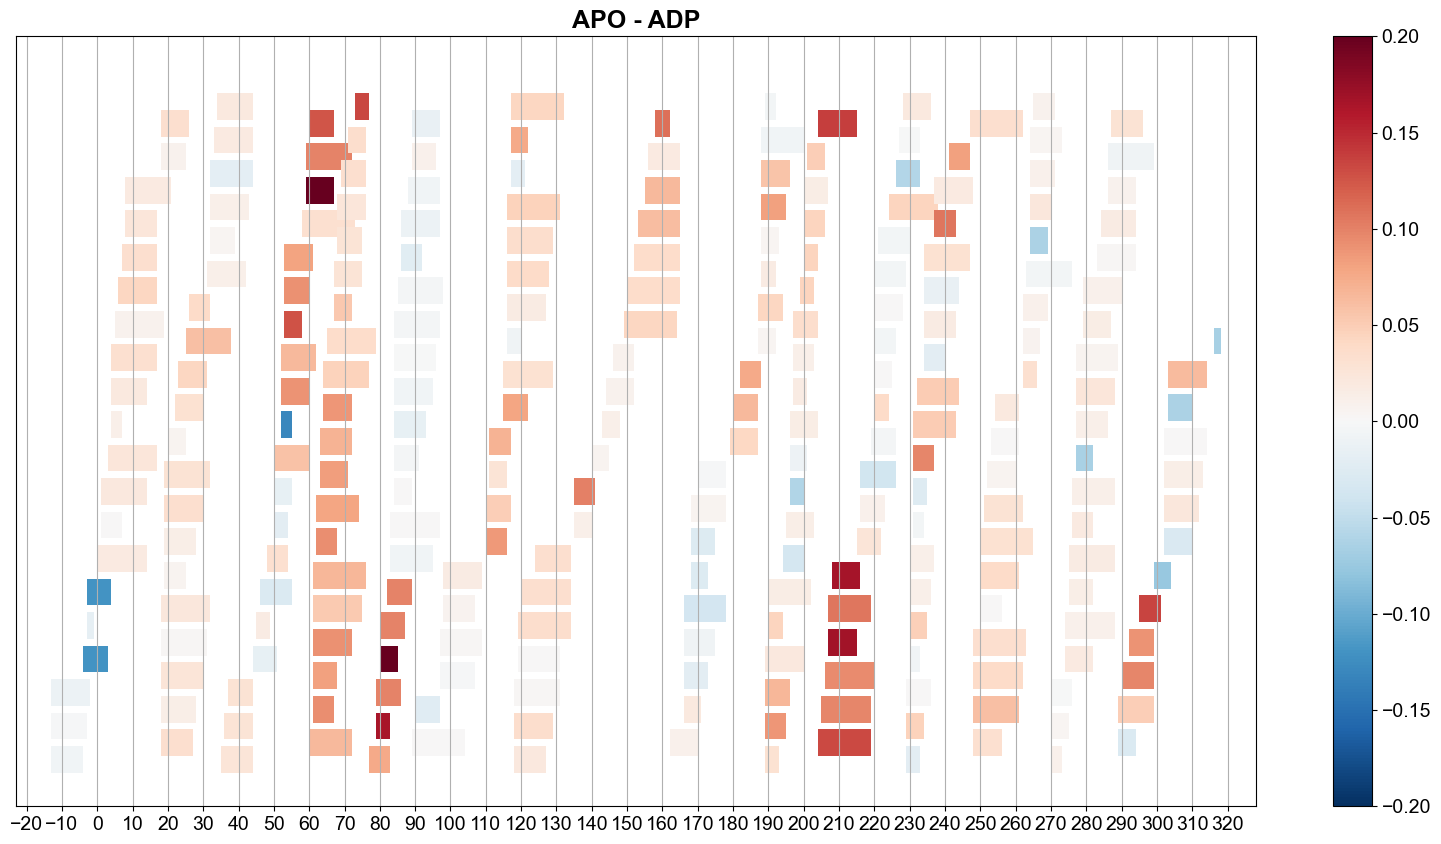

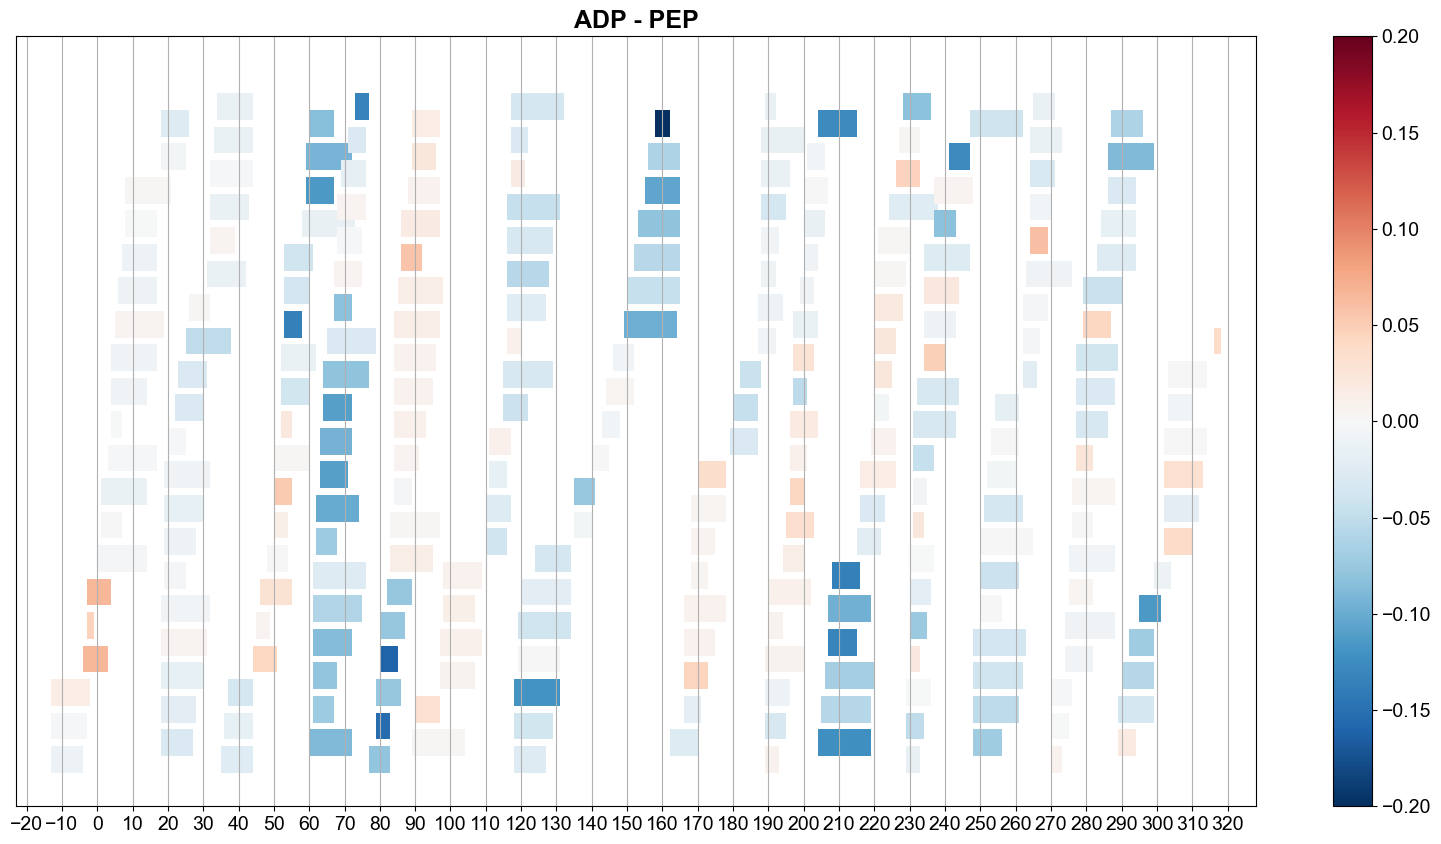

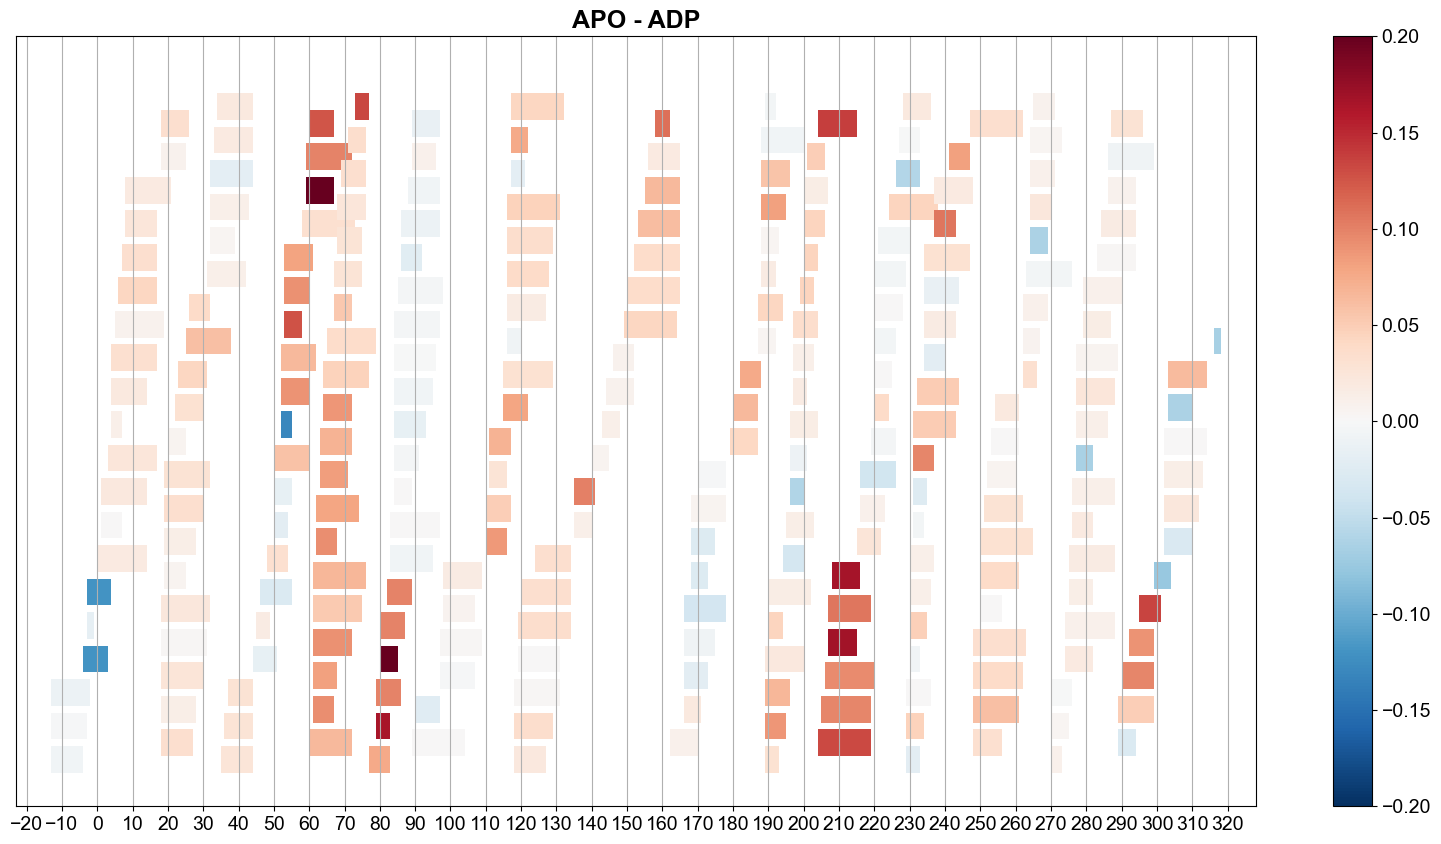

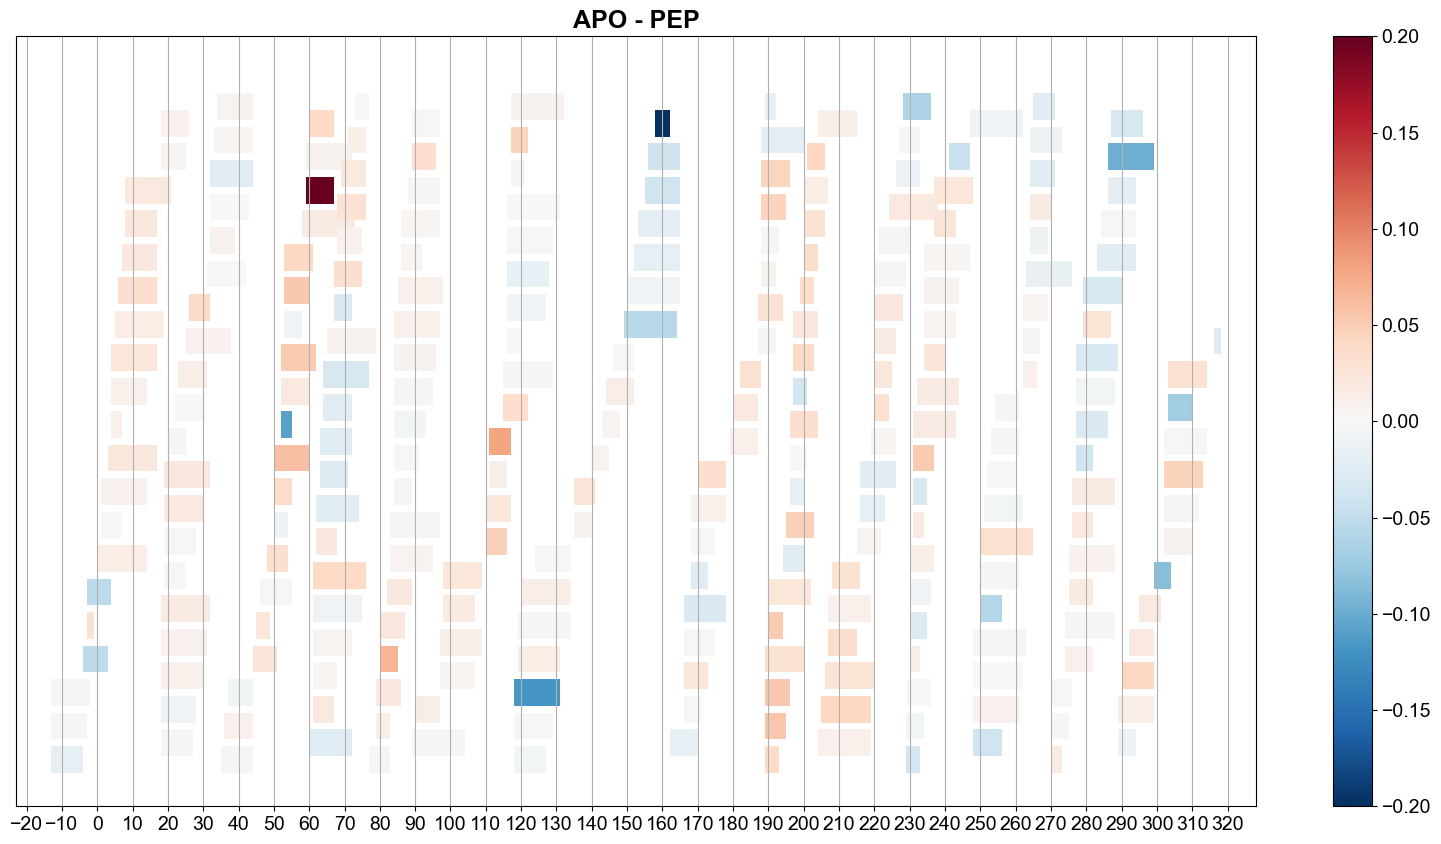

In [12]:
import matplotlib.colors as col
from matplotlib.patches import Rectangle
from matplotlib import cm
import pandas as pd


def process_df(df, top, colormap):
    s = df['Sensitivity'].copy()
    s = (s + top) / (2 * top)
    s.clip(upper=1, lower=0, inplace=True)
    rgb = colormap(s)*255
    new_df = pd.DataFrame({
        'Sequence': df['Sequence'],
        'r': rgb[:,0],
        'g': rgb[:,1],
        'b': rgb[:,2],
    })
    return new_df


def sort_df(df):
    df.sort_values(by='Sequence', key=lambda ser: [len(s.split()[1]) for s in ser], ascending=False, inplace=True)
    df.reset_index(inplace=True)
    return df


def color_cmd(rgb):
    cmd.color("gray")
    for i, seq in enumerate(rgb['Sequence']):
        seq = seq.split()[-1]
        cmd.select(seq, 'pepseq ' + seq)
        cmd.set_color(seq, [rgb['r'][i], rgb['g'][i], rgb['b'][i]])
        cmd.color(seq, seq)
    cmd.ray(1000,1000)



colormap = plt.get_cmap("RdBu_r")

for pair in pairs:
    pair_tuple = tuple(pair)
    dDt_tps_dict = dDt_tps_dict_dict.get(pair_tuple)
    dDS_dict = dDS_dict_dict.get(pair_tuple)

    try:
        dDbar_heatmap_df = process_dDbar_df(pair, peptides_2, dDbar_dict_dict)
    except:
        continue # no common peptides

    rgb_df = process_df(dDbar_heatmap_df, colorbar_max, colormap)
    sorted_rgb_df = sort_df(rgb_df)
    
    #color_cmd(sorted_rgb_df)
    #cmd.save(f'plots/{"-".join(pair)}-pm.pse')

    save_df_plot(pair, dDbar_heatmap_df, colormap, 0.2, index_shift=-14)

